Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.64963 154.444; 7.73023 155.034; … ; 8.12966 154.517; 7.09619 154.599]

Union{Missing, Float64}[8.01572 154.477; 8.02449 154.495; … ; 7.858 154.969; 7.858 154.969]

Union{Missing, Float64}[8.20113 154.225; 7.6422 154.531; … ; 7.65991 154.934; 7.75458 154.402]

Union{Missing, Float64}[7.58955 154.804; 7.66354 155.192; … ; 7.75214 154.484; 7.82778 153.74]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD       Naive SE         MCSE         ESS
sigma   7.7733674 0.29721958 0.004699454 5.66236168987×10⁻³ 1000
   mu 154.6081518 0.41195471 0.006513576 5.66327547345×10⁻³ 1000

Quantiles:
         2.5%       25.0%     50.0%      75.0%      97.5%  
sigma   7.223225   7.580115   7.75739   7.958195   8.407037
   mu 153.811000 154.339000 154.60100 154.875000 155.442075



Plot the density of posterior draws

┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ 

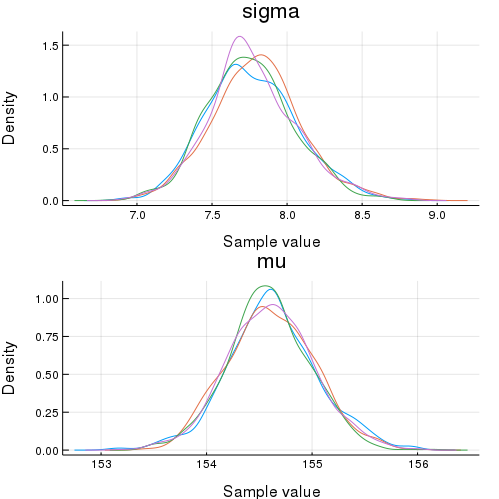

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.18747248335435412
 0.09218663514503743

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0516163
 0.0516163  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*